# Forsøk på debugging

### Imports

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from time import time

In [6]:
def read_dataset(filename, campaign=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving')]

    if campaign != None:
        df = df[df['campaign'] == campaign]

    X, y = df[['RSRP', 'SSS_RSRP', 'campaign', 'Mode']], df['Mode']
    return X, y


def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        # find the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f): # check to see if we are bwyond the data set
            break

        if curr_campaign == '': # set new current campaign if there is np campaign
            curr_campaign = f['campaign'].iloc[i]
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1: # check to see if in transition between two campaigns
            continue
        elif curr_campaign != f['campaign'].iloc[i]: # set new campaign equal to current if this is the campaign we are looping through
            curr_campaign = f['campaign'].iloc[i]
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)
    return np.array(X), np.array(y)


def vertical_handover(y):
    new_y = []
    for seq in y:
        if 0 in seq and 1 in seq:
            new_y.append(1)
        else:
            new_y.append(0)
    return np.array(new_y)


def check_handover(y):
    new_y = []
    for i in range(len(y) - 1):
        if y[i] == y[i+1]:
            new_y.append(0)
        else:
            new_y.append(1)
    return np.array(new_y)

In [7]:
campaign='Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode'
X, y = read_dataset('datasets/Op1_merged.csv', campaign=campaign)

n_steps_in, n_steps_out = 15, 1
X, y = series_split_sequences(X, y, n_steps_in, n_steps_out)

train_size = len(y) // 3 * 2
test_size = (len(y) - train_size) // 2 + train_size

X_train, y_train = X[0 : train_size], y[0 : train_size]
X_val, y_val = X[train_size : test_size], y[train_size : test_size]
X_test, y_test = X[test_size ::], y[test_size ::]
y_test_changed = vertical_handover(y_test)

n_features = X_train.shape[2]

In [8]:
model = Sequential()
model.add(LSTM(input_shape=(n_steps_in, n_features), units=200,
               activation='relu', recurrent_activation='sigmoid',
               return_sequences=True, return_state=False
              ))
model.add(LSTM(units=200,
               activation='relu', recurrent_activation='sigmoid',
               return_sequences=False, return_state=False
              ))
model.add(Dense(n_steps_out, activation='sigmoid'))
model.compile(loss='mean_squared_error',
              metrics=['accuracy'],
              optimizer='adam')
print(model.summary())

lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
early_stop = EarlyStopping(monitor='val_loss',
                           patience=80, mode='min'
                           #restore_best_weights=True
                           )

/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 15, 200)        │       163,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 200)            │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 484,201 (1.85 MB)

 Trainable params: 484,201 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

None


In [9]:
start = time()
History = model.fit(X_train, y_train,
                    epochs=100,
                    validation_data=(X_val, y_val),
                    shuffle=True, verbose=0)
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)

-----------------------------------------------------------------
Training was completed in 262.73 secs
-----------------------------------------------------------------


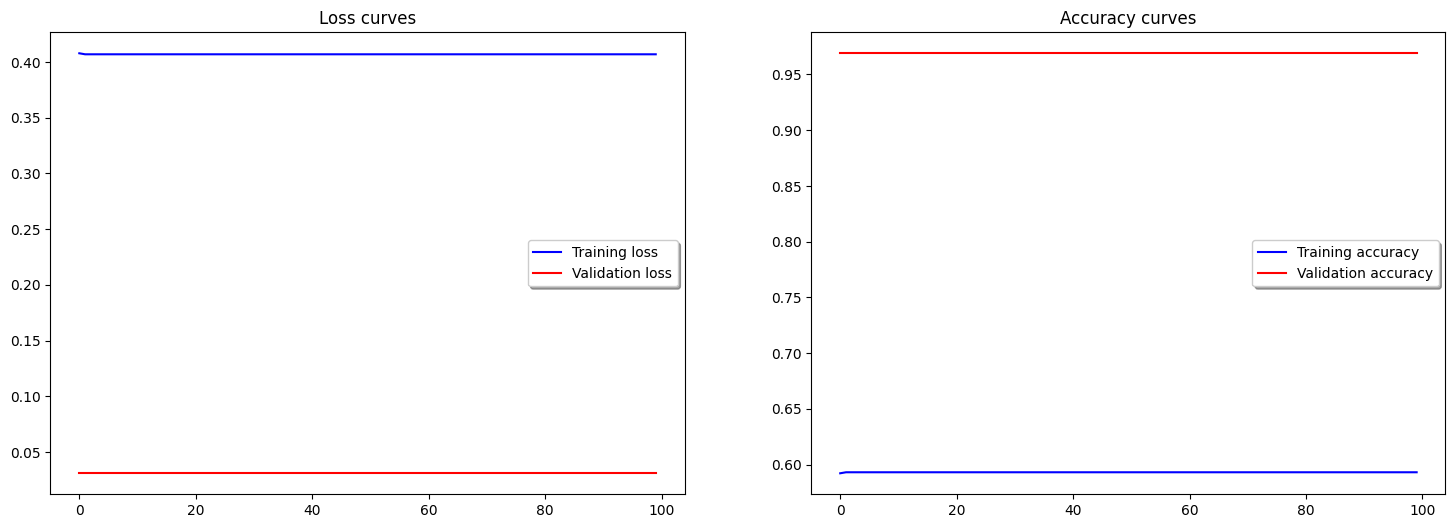

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [14]:
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
y_pred_changed = check_handover(y_pred)

print(np.unique(y_pred))

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[0]
